In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from collections import defaultdict
from surprise.model_selection import KFold
import warnings
warnings.filterwarnings('ignore')

In [38]:
rating=pd.read_csv("/kaggle/input/movielens/ratings.csv")

In [43]:
new=rating.copy()

In [44]:
new.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
new.tail()

,userId,movieId,rating,timestamp
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663
100003,671,6565,3.5,1074784724


In [6]:
new.shape

(100004, 4)

In [7]:
new.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100004.0,3.470113e+02,1.951638e+02,1.0,182.0,3.670000e+02,5.200000e+02,6.710000e+02
movieId,100004.0,1.254866e+04,2.636920e+04,1.0,1028.0,2.406500e+03,5.418000e+03,1.639490e+05
rating,100004.0,3.543608e+00,1.058064e+00,0.5,3.0,4.000000e+00,4.000000e+00,5.000000e+00
timestamp,100004.0,1.129639e+09,1.916858e+08,789652009.0,965847824.0,1.110422e+09,1.296192e+09,1.476641e+09


0.5     1101
1.0     3326
1.5     1687
2.0     7271
2.5     4449
3.0    20064
3.5    10538
4.0    28750
4.5     7723
5.0    15095
Name: rating, dtype: int64


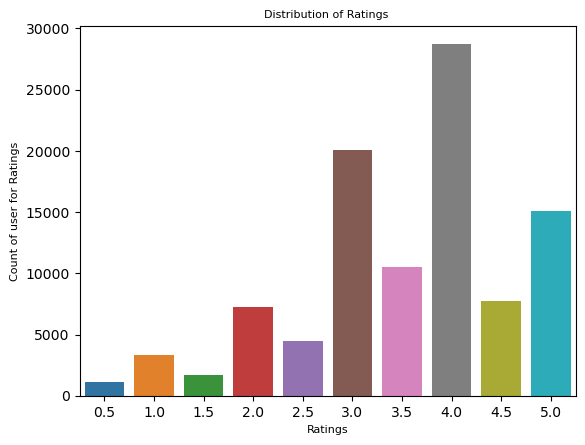

In [52]:
rating_count = new['rating'].value_counts().sort_index()
print(rating_count)
sns.countplot(x="rating" ,data=rating)
plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 8)
plt.xlabel("Ratings", fontsize = 8)
plt.ylabel("Count of user for Ratings", fontsize = 8)
plt.show()

1. The structure contains of mainly three things rating,movie and user
1. The user with rating 4 has highest count i.e near 28000 and  user with rating 0.5 has least count 

In [13]:
unique_users = new['userId'].nunique()
unique_movies = new['movieId'].nunique()
print("Number of Unique Users:", unique_users)
print("Number of Unique Movies:", unique_movies)

Number of Unique Users: 671
Number of Unique Movies: 9066


In [25]:
new.groupby(['userId', 'movieId']).count()

rating  timestamp
userId movieId                   
1      31            1          1
       1029          1          1
       1061          1          1
       1129          1          1
       1172          1          1
...                ...        ...
671    6268          1          1
       6269          1          1
       6365          1          1
       6385          1          1
       6565          1          1

[100004 rows x 2 columns]

In [26]:
new.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

Since the sum and no of rows is same so there is no movie in which the same user interacted with it more than once

In [27]:
rating['movieId'].value_counts()

356       341
296       324
318       311
593       304
260       291
         ... 
98604       1
103659      1
104419      1
115927      1
6425        1
Name: movieId, Length: 9066, dtype: int64

Since movieId 356 has more more interactions lets plot against it

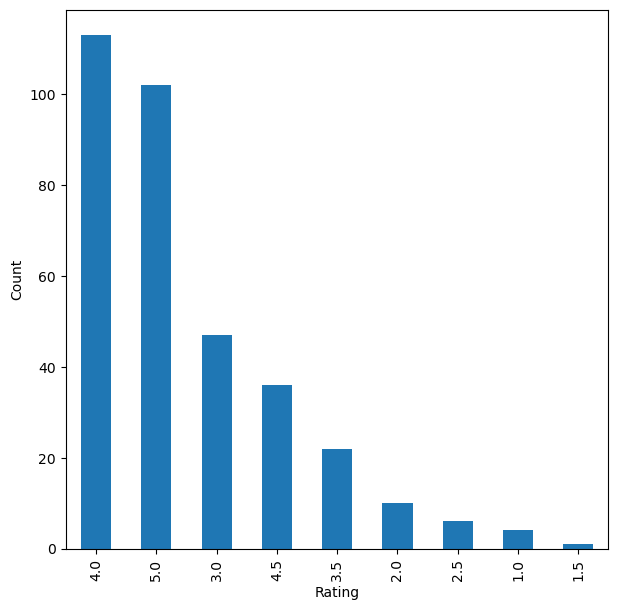

In [28]:
plt.figure(figsize=(7,7))

new[new['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

Here we can more users have rated 4 and least no of people voted 1.5

In [29]:
new['userId'].value_counts()

547    2391
564    1868
624    1735
15     1700
73     1610
       ... 
296      20
289      20
249      20
221      20
1        20
Name: userId, Length: 671, dtype: int64

The user with userId 547 interacts the most with any movie in the dataset

In [46]:
interactions = rating.groupby('userId').count()['movieId']
interactions

userId
1       20
2       76
3       51
4      204
5      100
      ... 
667     68
668     20
669     37
670     31
671    115
Name: movieId, Length: 671, dtype: int64

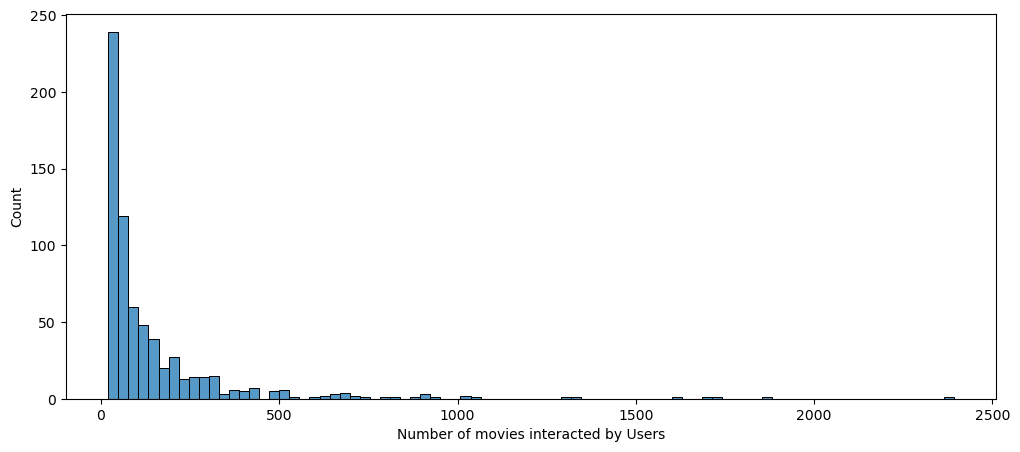

In [51]:
plt.figure(figsize=(12,5))
sns.histplot(interactions)
plt.xlabel('Number of movies interacted by Users')
plt.show()

1. The highest number of movie-user interactions are less than 500 movies,beyond that few movies are present but are widely distributed
1. The gragh is heavily left skewed

# **Create Rank Based Recommendation System**

In [54]:
average_rating = rating.groupby('movieId').mean()['rating']
count_rating = rating.groupby('movieId').count()['rating']
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [55]:
final_rating.head()

,avg_rating,rating_count
movieId,,
1,3.872470,247
2,3.401869,107
3,3.161017,59
4,2.384615,13
5,3.267857,56


In [58]:
def top_nmovies(new, n, min_interaction=100):
    recom = new[new['rating_count'] > min_interaction]
    recom = recom.sort_values(by='avg_rating', ascending=False)
    return recom.index[:n]

**Recommending top 6 movies with 80 minimum interactions based on popularity**

In [59]:
list(top_nmovies(final_rating ,6 ,80))

[858, 318, 1221, 50, 904, 527]

**Recommending top 8movies with 150 interactions based on popularity**

In [60]:
list(top_nmovies(final_rating ,8,150))

[858, 318, 50, 527, 608, 296, 2858, 1196]

#  Build a User based Collaborative Filtering Recommendation System

In [62]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [70]:
from surprise import KNNBasic
alg = KNNBasic()
sim_options = {'name': 'cosine',
               'user_based': True}

alg_knnuser = KNNBasic(sim_options=sim_options,verbose=False)
alg_knnuser.fit(trainset)
predictions = alg_knnuser.test(testset)
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

**predict rating for an user with userId=4 and for movieId=10**

In [140]:
alg_knnuser.predict(4, 10,r_ui=4, verbose=True)


user: 4          item: 10         r_ui = 4.00   est = 3.54   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.538364234003973, details={'actual_k': 40, 'was_impossible': False})

Predicted score is 3.54 while true value is 4

**predict rating for an user with userId=4 and for movieId=3**

In [72]:
alg_knnuser.predict(4, 3,verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

Predicted score is 3.2 while true value is unknown

In [75]:
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],'sim_options': {'name': ['msd', 'cosine','pearson'],'user_based': [True]}}
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
grid_obj.fit(data)
print(grid_obj.best_score['rmse'])
print(grid_obj.best_params['rmse'])

0.9652238701204131
{'k': 20, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': True}}


In [78]:
similar = {'name': 'msd','user_based': True}
similarity_based_user = KNNBasic(sim_options=sim_options, k=20, min_k=3,verbose=False)
similarity_based_user.fit(trainset)
predict = similarity_based_user.test(testset)
accuracy.rmse(predict)

RMSE: 0.9571


0.9571445417153293

**predict rating for an user with userId=4 and for movieId=10**

In [141]:
similarity_based_user.predict(4,10,r_ui=4,verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.68   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6795726196901404, details={'actual_k': 30, 'was_impossible': False})

Predicted score is 3.68 while true value is 4 there is improvement

**predict rating for an user with userId=4 and for movieId=3**

In [81]:
similarity_based_user.predict(4,3,verbose=True)

user: 4          item: 3          r_ui = None   est = 3.72   {'actual_k': 20, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7228745701935386, details={'actual_k': 20, 'was_impossible': False})

Predicted score is 3.72 while true value is unknown there is improvement

# Similarity Based Recommendation System

Predict the top 5 movies for userId=4 with similarity based recommendation system

In [89]:
def get_recommendations(data, user_id, topn, alg):
    recommend = []
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    for item_id in non_interacted_movies:
        est = alg.predict(user_id, item_id).est
        recommend.append((item_id, est))
    recommend.sort(key=lambda x: x[1], reverse=True)
    return recommend[:topn]

In [91]:
recommend = get_recommendations(rating, 4, 5, similarity_based_user)

In [93]:
recommend

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

# Item based Collaborative Filtering Recommendation System

In [94]:
sim = {'name': 'cosine','user_based': False}
algoknn_item = KNNBasic(sim_options=sim,verbose=False)
algoknn_item.fit(trainset)
predictions = algoknn_item.test(testset)
accuracy.rmse(predictions)

RMSE: 1.0032


1.003221450633729

**predict rating for an user with userId=4 and for movieId=10**

In [142]:
algoknn_item.predict(4,10,r_ui=4,verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.25   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.248452088758312, details={'actual_k': 40, 'was_impossible': False})

Predicted score is 4.25 while true value is 4

**predict rating for an user with userId=4 and for movieId=3**

In [96]:
algoknn_item.predict(4,3,verbose=True)

user: 4          item: 3          r_ui = None   est = 4.07   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.071601862880049, details={'actual_k': 40, 'was_impossible': False})

Predicted score is 4.07 while true value is unknown

In [103]:
param_grid = {'k': [20, 30], 'min_k': [3],'sim_options': {'name': ['msd', 'cosine',],'user_based': [False]}}
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
grid_obj.fit(data)
print(grid_obj.best_score['rmse'])
print(grid_obj.best_params['rmse'])

0.9431180667112754
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'msd', 'user_based': False}}


In [134]:
similar = {'name': 'msd','user_based': True}
similarity_based_item = KNNBasic(sim_options=sim_options, k=30, min_k=3,verbose=False)
similarity_based_item.fit(trainset)
predict = similarity_based_item.test(testset)
accuracy.rmse(predict)

RMSE: 0.9594


0.9594349028947148

**predict rating for an user with userId=4 and for movieId=10**

In [143]:
similarity_based_item.predict(4,10,r_ui=4,verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.76   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.764480564107267, details={'actual_k': 30, 'was_impossible': False})

Predicted score is 3.76 while true value is 4

**predict rating for an user with userId=4 and for movieId=2**

In [136]:
similarity_based_item.predict(4,3,verbose=True)

user: 4          item: 3          r_ui = None   est = 3.45   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.4483196919285954, details={'actual_k': 30, 'was_impossible': False})

Predicted score is 3.45 while true value is unknown

# Similarity Based Recommendation System

In [111]:
def get_recommendations(data, user_id, topn, alg):
    recommend = []
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    for item_id in non_interacted_movies:
        est = alg.predict(user_id, item_id).est
        recommend.append((item_id, est))
    recommend.sort(key=lambda x: x[1], reverse=True)
    return recommend[:topn]

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [137]:
recommend = get_recommendations(rating, 4, 5, similarity_based_item)
recommend

[(309, 5),
 (3038, 5),
 (6273, 4.928202652354184),
 (98491, 4.863224466679252),
 (2721, 4.845513973527148)]

#  matrix factorization recommendation system

In [117]:
alg_svd = SVD()
alg_svd.fit(trainset)
predict = alg_svd.test(testset)
accuracy.rmse(predict)

RMSE: 0.9034


0.9033975796495052

**predict rating for an user with userId=4 and for movieId=10**

In [119]:
alg_svd.predict(4,10,verbose=True)

user: 4          item: 10         r_ui = None   est = 4.13   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=None, est=4.125617043675502, details={'was_impossible': False})

**predict rating for an user with userId=4 and for movieId=3**

In [120]:
alg_svd.predict(4,3,verbose=True)

user: 4          item: 3          r_ui = None   est = 3.71   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.7149952020107544, details={'was_impossible': False})

In [122]:
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],'reg_all': [0.2, 0.4, 0.6]}
grid = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)
grid.fit(data)
print(grid.best_score['rmse'])
print(grid.best_params['rmse'])

0.9784421366128724
{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}


In [123]:
svd_based_user = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)
svd_based_user.fit(trainset)
predict = svd_based_user.test(testset)
accuracy.rmse(predict)

RMSE: 0.8954


0.8953611072927974

**predict rating for an user with userId=4 and for movieId=10**

In [144]:
svd_based_user.predict(4,10,r_ui=4,verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.03   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.0303528502223696, details={'was_impossible': False})

Predicted score is 3.99 while true value is 4

**predict rating for an user with userId=4 and for movieId=3**

In [126]:
svd_based_user.predict(4,3,verbose=True)

user: 4          item: 3          r_ui = None   est = 3.65   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6455961704991635, details={'was_impossible': False})

Predicted score is 3.65 while true value is unknown

In [128]:
get_recommendations(rating, 4, 5, svd_based_user)

[(1192, 4.9780498155425),
 (3310, 4.960468383340618),
 (1948, 4.9592514657351945),
 (926, 4.938061206570177),
 (116, 4.92520963143994)]

#  Compute the precision and recall, for each of the 6 models, at k = 5 and 10

In [130]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

In [139]:
kfd = KFold(n_splits=5)
K = [5,10]
models = [alg_knnuser, similarity_based_user,algoknn_item,similarity_based_item, alg_svd, svd_based_user]
for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kfd.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.767
-----> Recall:  0.412
> k=5, model=KNNBasic
-----> Precision:  0.774
-----> Recall:  0.419
> k=5, model=KNNBasic
-----> Precision:  0.607
-----> Recall:  0.323
> k=5, model=KNNBasic
-----> Precision:  0.777
-----> Recall:  0.417
> k=5, model=SVD
-----> Precision:  0.75
-----> Recall:  0.381
> k=5, model=SVD
-----> Precision:  0.748
-----> Recall:  0.385
> k=10, model=KNNBasic
-----> Precision:  0.751
-----> Recall:  0.549
> k=10, model=KNNBasic
-----> Precision:  0.751
-----> Recall:  0.557
> k=10, model=KNNBasic
-----> Precision:  0.6
-----> Recall:  0.48
> k=10, model=KNNBasic
-----> Precision:  0.755
-----> Recall:  0.557
> k=10, model=SVD
-----> Precision:  0.732
-----> Recall:  0.515
> k=10, model=SVD
-----> Precision:  0.731
-----> Recall:  0.523


# results and provide insights

1. baseline user-user and item-item-based models have good precsion value but the recall is quite low especially during k=5
   the precsion are below 0.5.
1. After tuning user-user model has not changed much but the item-item model precision and recall value has improved
1. By verifying RMSE values we can tell that after tuning user-user and item-item-based models have both improved
1. The matrix factorization model is different from the collaborative filtering models. Briefly describe this difference.Collaborative filtering (CF) and matrix factorization (MF) are two popular techniques used in recommendation systems. The main difference between them is the way they approach the recommendation task.Collaborative filtering methods analyze user behavior, such as their interactions with items (e.g., ratings, purchases, clicks), and use this information to identify patterns and similarities among users and items. CF-based recommenders then suggest items to users based on the preferences of similar users.In contrast, matrix factorization techniques use matrix decomposition to identify latent factors that explain user-item interactions. The factorization process involves breaking down a large matrix of user-item interactions into smaller matrices that capture underlying patterns and relationships between users and items. These smaller matrices are then used to generate recommendations.In summary, while both collaborative filtering and matrix factorization are used for recommendation systems, collaborative filtering uses user behavior to identify similar users and recommend items, while matrix factorization uses matrix decomposition to identify latent factors and generate recommendations based on these factors.
1. No,there is no improvement between RMSE and precision-recall,It is possible for a model to improve in both metrics, but this is not always the case. Improvements in one metric may come at the cost of another metric. For example, increasing the number of features in a model may improve its RMSE but decrease its precision and recall.

1. In general, the improvement in either metric depends on the nature of the data and the specific modeling techniques used. It is important to choose the appropriate evaluation metric based on the problem at hand and interpret the results in the context of the specific application.